In [1]:
import torch
import pandas as pd
from pathlib import Path
from torch.profiler import profile, record_function, ProfilerActivity
import time
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib.style.use("fivethirtyeight")
# matplotlib.style.use("seaborn-v0_8-talk")
matplotlib.rcParams["font.family"] = "monospace"
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams["savefig.facecolor"] = "white"

torch.random.manual_seed(0)

print(torch.__version__)

2.0.0.dev20230213+cu117


In [1]:
DEVICE = "cuda"
PROFILER_OUTDIR = Path("profiler_output")
PATCH_SIZE = 16
NUM_REPEATS = 1

densify = lambda x: x.to_dense() if x.is_sparse else x
cooify = lambda x: x.to_sparse_coo()
cscify = lambda x: x.to_sparse_csc()
csrify = lambda x: x.to_sparse_csr()
bsrify = lambda x: x.to_sparse_bsr((16, 16))

MATRIX_TYPES = [
    ("dense", densify),
    ("coo", cooify),
    # ("csc", cscify),
    ("csr", csrify),
    ("bsr", bsrify),
]

NameError: name 'Path' is not defined

In [3]:
SIZES = [512, 1024, 2048, 4096, 8192, 16384]
PERCENTAGES_NONZERO = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]


def run_benchmark(profiling=False):
    results = []
    for size in SIZES:
        b = torch.rand((size, 1), device=DEVICE, dtype=torch.float32)
        for percentage_nonzero in PERCENTAGES_NONZERO:
            # Define the number of patches to set to a non-zero value
            num_patches = math.ceil(size**2 * percentage_nonzero / PATCH_SIZE**2)
            # Create a tensor of zeros with the specified shape
            A_dense = torch.zeros((size, size), device=DEVICE, dtype=torch.float32)
            # Set a random set of patches to random values
            for i in range(num_patches):
                # Generate random row and column indices for the top-left corner of the patch
                row_idx = torch.randint(size - PATCH_SIZE + 1, (1,))
                col_idx = torch.randint(size - PATCH_SIZE + 1, (1,))
                # Generate a random patch with values between min_value and max_value
                patch = torch.rand((PATCH_SIZE, PATCH_SIZE))
                # Set the patch in the dense matrix
                A_dense[
                    row_idx : row_idx + PATCH_SIZE, col_idx : col_idx + PATCH_SIZE
                ] = patch

            archieved_percentage = A_dense.count_nonzero() / (size * size)
            print(
                f"Running {size}x{size} with {percentage_nonzero * 100}% non-zero (achieved {archieved_percentage * 100}%)"
            )

            for name, matrix_fun in MATRIX_TYPES:
                matrix = matrix_fun(A_dense)
                # warm up
                _ = torch.matmul(matrix, b)
                start_time = time.time_ns()
                with profile(
                    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                    with_stack=profiling,
                    record_shapes=profiling,
                ) as prof:
                    for _ in range(NUM_REPEATS):
                        _ = torch.matmul(matrix, b)
                torch.cuda.synchronize()
                end_time = time.time_ns()
                print(
                    f"  {name} took {(end_time - start_time) / NUM_REPEATS / 10**6} ms"
                )
                result = {
                    "size": size,
                    "percentage_nonzero": percentage_nonzero,
                    "name": name,
                    "cuda_micros": prof.key_averages()
                    .total_average()
                    .self_cuda_time_total
                    / NUM_REPEATS,
                    "cpu_micros": prof.key_averages()
                    .total_average()
                    .self_cpu_time_total
                    / NUM_REPEATS,
                    "measured_time": (end_time - start_time) / NUM_REPEATS,
                }
                results.append(result)
                if profiling:
                    prof.export_chrome_trace(
                        str(
                            PROFILER_OUTDIR
                            / f"torch_sparse_{size}_{percentage_nonzero}_{name}.json"
                        )
                    )
                    prof.export_stacks(
                        str(
                            PROFILER_OUTDIR
                            / f"torch_sparse_stacks_{size}_{percentage_nonzero}_{name}.txt"
                        ),
                        "self_cuda_time_total",
                    )
    return results


results = run_benchmark(profiling=False)
df = pd.DataFrame(results)
df.to_csv(PROFILER_OUTDIR / "torch_sparse_results.csv", index=False)

Running 512x512 with 0.01% non-zero (achieved 0.09765625%)


STAGE:2023-02-17 19:59:43 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


  dense took 1.0738131999969482 seconds
  coo took 0.0038568973541259766 seconds
  csr took 0.0025453567504882812 seconds
  bsr took 0.0036907196044921875 seconds
Running 512x512 with 0.1% non-zero (achieved 0.1953125%)
  dense took 0.0012509822845458984 seconds
  coo took 0.003376483917236328 seconds
  csr took 0.0027244091033935547 seconds
  bsr took 0.002619504928588867 seconds
Running 512x512 with 1.0% non-zero (achieved 1.07421875%)
  dense took 0.0011844635009765625 seconds
  coo took 0.0034759044647216797 seconds
  csr took 0.0016908645629882812 seconds
  bsr took 0.002619504928588867 seconds
Running 512x512 with 5.0% non-zero (achieved 4.8694610595703125%)
  dense took 0.0011968612670898438 seconds
  coo took 0.00333404541015625 seconds
  csr took 0.002687692642211914 seconds
  bsr took 0.0025548934936523438 seconds
Running 512x512 with 10.0% non-zero (achieved 9.399795532226562%)
  dense took 0.001186370849609375 seconds
  coo took 0.003505706787109375 seconds
  csr took 0.001

STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
/tmp/ipykernel_150075/3408620248.py:8: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  csrify = lambda x : x.to_sparse_csr()
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:44 150

  bsr took 0.0027163028717041016 seconds
Running 1024x1024 with 5.0% non-zero (achieved 4.88433837890625%)
  dense took 0.0011963844299316406 seconds
  coo took 0.0034303665161132812 seconds
  csr took 0.0016775131225585938 seconds
  bsr took 0.0035135746002197266 seconds
Running 1024x1024 with 10.0% non-zero (achieved 9.510231018066406%)
  dense took 0.0011739730834960938 seconds
  coo took 0.003326892852783203 seconds
  csr took 0.0038895606994628906 seconds
  bsr took 0.002572298049926758 seconds
Running 1024x1024 with 20.0% non-zero (achieved 18.00537109375%)
  dense took 0.001177072525024414 seconds
  coo took 0.0025985240936279297 seconds
  csr took 0.0016682147979736328 seconds
  bsr took 0.0026264190673828125 seconds
Running 1024x1024 with 30.0% non-zero (achieved 25.64849853515625%)
  dense took 0.0011730194091796875 seconds
  coo took 0.0024504661560058594 seconds
  csr took 0.001811981201171875 seconds
  bsr took 0.0025501251220703125 seconds
Running 2048x2048 with 0.01% non

STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:44 150075:150075 ActivityProfilerCo

  bsr took 0.0028145313262939453 seconds
Running 2048x2048 with 0.1% non-zero (achieved 0.103759765625%)
  dense took 0.0012917518615722656 seconds
  coo took 0.0024449825286865234 seconds
  csr took 0.001672506332397461 seconds
  bsr took 0.00257110595703125 seconds
Running 2048x2048 with 1.0% non-zero (achieved 0.9983301162719727%)
  dense took 0.0012831687927246094 seconds
  coo took 0.0024766921997070312 seconds
  csr took 0.0018582344055175781 seconds
  bsr took 0.002600431442260742 seconds
Running 2048x2048 with 5.0% non-zero (achieved 4.902076721191406%)
  dense took 0.0014102458953857422 seconds
  coo took 0.0027437210083007812 seconds
  csr took 0.0017282962799072266 seconds
  bsr took 0.002709627151489258 seconds
Running 2048x2048 with 10.0% non-zero (achieved 9.5062255859375%)
  dense took 0.0013284683227539062 seconds
  coo took 0.0024957656860351562 seconds
  csr took 0.0018656253814697266 seconds
  bsr took 0.002625703811645508 seconds
Running 2048x2048 with 20.0% non-zer

STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerCo

Running 2048x2048 with 30.0% non-zero (achieved 25.93929672241211%)
  dense took 0.0013196468353271484 seconds
  coo took 0.0025637149810791016 seconds
  csr took 0.001722574234008789 seconds
  bsr took 0.0027649402618408203 seconds
Running 4096x4096 with 0.01% non-zero (achieved 0.01068115234375%)
  dense took 0.0014083385467529297 seconds
  coo took 0.002492189407348633 seconds
  csr took 0.0018475055694580078 seconds
  bsr took 0.0025801658630371094 seconds
Running 4096x4096 with 0.1% non-zero (achieved 0.1007080078125%)
  dense took 0.0014002323150634766 seconds
  coo took 0.0026459693908691406 seconds
  csr took 0.0016741752624511719 seconds
  bsr took 0.00266265869140625 seconds
Running 4096x4096 with 1.0% non-zero (achieved 0.9971380233764648%)
  dense took 0.00138092041015625 seconds
  coo took 0.0024602413177490234 seconds
  csr took 0.0018310546875 seconds
  bsr took 0.0025734901428222656 seconds


STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerCo

Running 4096x4096 with 5.0% non-zero (achieved 4.889040946960449%)
  dense took 0.0015609264373779297 seconds
  coo took 0.0026624202728271484 seconds
  csr took 0.0017015933990478516 seconds
  bsr took 0.0027718544006347656 seconds


STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:45 150075:150075 ActivityProfilerCo

Running 4096x4096 with 10.0% non-zero (achieved 9.497154235839844%)
  dense took 0.0014431476593017578 seconds
  coo took 0.0026237964630126953 seconds
  csr took 0.001728057861328125 seconds
  bsr took 0.002875804901123047 seconds


STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerCo

Running 4096x4096 with 20.0% non-zero (achieved 18.070781707763672%)
  dense took 0.001764535903930664 seconds
  coo took 0.0029175281524658203 seconds
  csr took 0.004277467727661133 seconds
  bsr took 0.002959728240966797 seconds


STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:46 150075:150075 ActivityProfilerCo

Running 4096x4096 with 30.0% non-zero (achieved 25.970632553100586%)
  dense took 0.0017235279083251953 seconds
  coo took 0.0034677982330322266 seconds
  csr took 0.002062559127807617 seconds
  bsr took 0.003355741500854492 seconds
Running 8192x8192 with 0.01% non-zero (achieved 0.0102996826171875%)
  dense took 0.0020101070404052734 seconds
  coo took 0.0028319358825683594 seconds
  csr took 0.0022492408752441406 seconds
  bsr took 0.0027735233306884766 seconds
Running 8192x8192 with 0.1% non-zero (achieved 0.1003265380859375%)
  dense took 0.00211334228515625 seconds
  coo took 0.003025054931640625 seconds
  csr took 0.002044677734375 seconds
  bsr took 0.002836942672729492 seconds


STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerCo

Running 8192x8192 with 1.0% non-zero (achieved 0.9949088096618652%)
  dense took 0.002115488052368164 seconds
  coo took 0.0030181407928466797 seconds
  csr took 0.002169370651245117 seconds
  bsr took 0.0028829574584960938 seconds


STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:47 150075:150075 ActivityProfilerCo

Running 8192x8192 with 5.0% non-zero (achieved 4.87746000289917%)
  dense took 0.0022499561309814453 seconds
  coo took 0.003935098648071289 seconds
  csr took 0.0028214454650878906 seconds
  bsr took 0.0033555030822753906 seconds


STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:48 150075:150075 ActivityProfilerCo

Running 8192x8192 with 10.0% non-zero (achieved 9.51530647277832%)
  dense took 0.002321481704711914 seconds
  coo took 0.0051915645599365234 seconds
  csr took 0.0030264854431152344 seconds
  bsr took 0.0034940242767333984 seconds


STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:49 150075:150075 ActivityProfilerCo

Running 8192x8192 with 20.0% non-zero (achieved 18.09665870666504%)
  dense took 0.0022554397583007812 seconds
  coo took 0.0069086551666259766 seconds
  csr took 0.0041425228118896484 seconds
  bsr took 0.003966331481933594 seconds


STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:52 150075:150075 ActivityProfilerCo

Running 8192x8192 with 30.0% non-zero (achieved 25.894420623779297%)
  dense took 0.002294778823852539 seconds
  coo took 0.009745359420776367 seconds
  csr took 0.004605531692504883 seconds
  bsr took 0.005008220672607422 seconds
Running 16384x16384 with 0.01% non-zero (achieved 0.010013580322265625%)
  dense took 0.003924131393432617 seconds
  coo took 0.0064585208892822266 seconds
  csr took 0.005333423614501953 seconds
  bsr took 0.0027055740356445312 seconds
Running 16384x16384 with 0.1% non-zero (achieved 0.0999942421913147%)


STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerCo

  dense took 0.0038628578186035156 seconds
  coo took 0.0063877105712890625 seconds
  csr took 0.004955768585205078 seconds
  bsr took 0.002602100372314453 seconds


STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:55 150075:150075 ActivityProfilerCo

Running 16384x16384 with 1.0% non-zero (achieved 0.9943537712097168%)
  dense took 0.0038881301879882812 seconds
  coo took 0.006902217864990234 seconds
  csr took 0.0051343441009521484 seconds
  bsr took 0.0029757022857666016 seconds


STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:56 150075:150075 ActivityProfilerCo

Running 16384x16384 with 5.0% non-zero (achieved 4.878818988800049%)
  dense took 0.0041866302490234375 seconds
  coo took 0.010752677917480469 seconds
  csr took 0.007527351379394531 seconds
  bsr took 0.0045318603515625 seconds


STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 19:59:58 150075:150075 ActivityProfilerCo

Running 16384x16384 with 10.0% non-zero (achieved 9.517190933227539%)
  dense took 0.004265308380126953 seconds
  coo took 0.015063762664794922 seconds
  csr took 0.009182214736938477 seconds
  bsr took 0.0068492889404296875 seconds


STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:03 150075:150075 ActivityProfilerCo

Running 16384x16384 with 20.0% non-zero (achieved 18.127391815185547%)
  dense took 0.00428009033203125 seconds
  coo took 0.02254199981689453 seconds
  csr took 0.012464523315429688 seconds
  bsr took 0.01021885871887207 seconds


STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:13 150075:150075 ActivityProfilerCo

Running 16384x16384 with 30.0% non-zero (achieved 25.910945892333984%)
  dense took 0.004273653030395508 seconds
  coo took 0.028489112854003906 seconds
  csr took 0.017073631286621094 seconds
  bsr took 0.011365175247192383 seconds


STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:27 150075:150075 ActivityProfilerCo

In [4]:
SIZES = [8192]
PERCENTAGES_NONZERO = [0.05]
_ = run_benchmark(profiling=True)

Running 8192x8192 with 5.0% non-zero (achieved 4.874083518981934%)
  dense took 0.0037975311279296875 seconds
  coo took 0.00476527214050293 seconds
  csr took 0.003013134002685547 seconds
  bsr took 0.0039825439453125 seconds


STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerController.cpp:321] Completed Stage: Post Processing
STAGE:2023-02-17 20:00:28 150075:150075 ActivityProfilerCo

In [5]:
df = pd.read_csv(PROFILER_OUTDIR / "torch_sparse_results.csv")
df["percentage_nonzero"] = df["percentage_nonzero"] * 100
df["cuda_millis"] = df["cuda_micros"] / 1000
df["cpu_millis"] = df["cpu_micros"] / 1000
df

,size,percentage_nonzero,name,cuda_micros,cpu_micros,measured_time,cuda_millis,cpu_millis
0,512,0.01,dense,14,828061,1.073813,0.014,828.061
1,512,0.01,coo,64,1627,0.003857,0.064,1.627
2,512,0.01,csr,26,1245,0.002545,0.026,1.245
3,512,0.01,bsr,32,1531,0.003691,0.032,1.531
4,512,0.10,dense,10,472,0.001251,0.010,0.472
...,...,...,...,...,...,...,...,...
163,16384,20.00,bsr,9606,8059,0.010219,9.606,8.059
164,16384,30.00,dense,5274,3144,0.004274,5.274,3.144
165,16384,30.00,coo,12714,26426,0.028489,12.714,26.426
166,16384,30.00,csr,4140,14148,0.017074,4.140,14.148


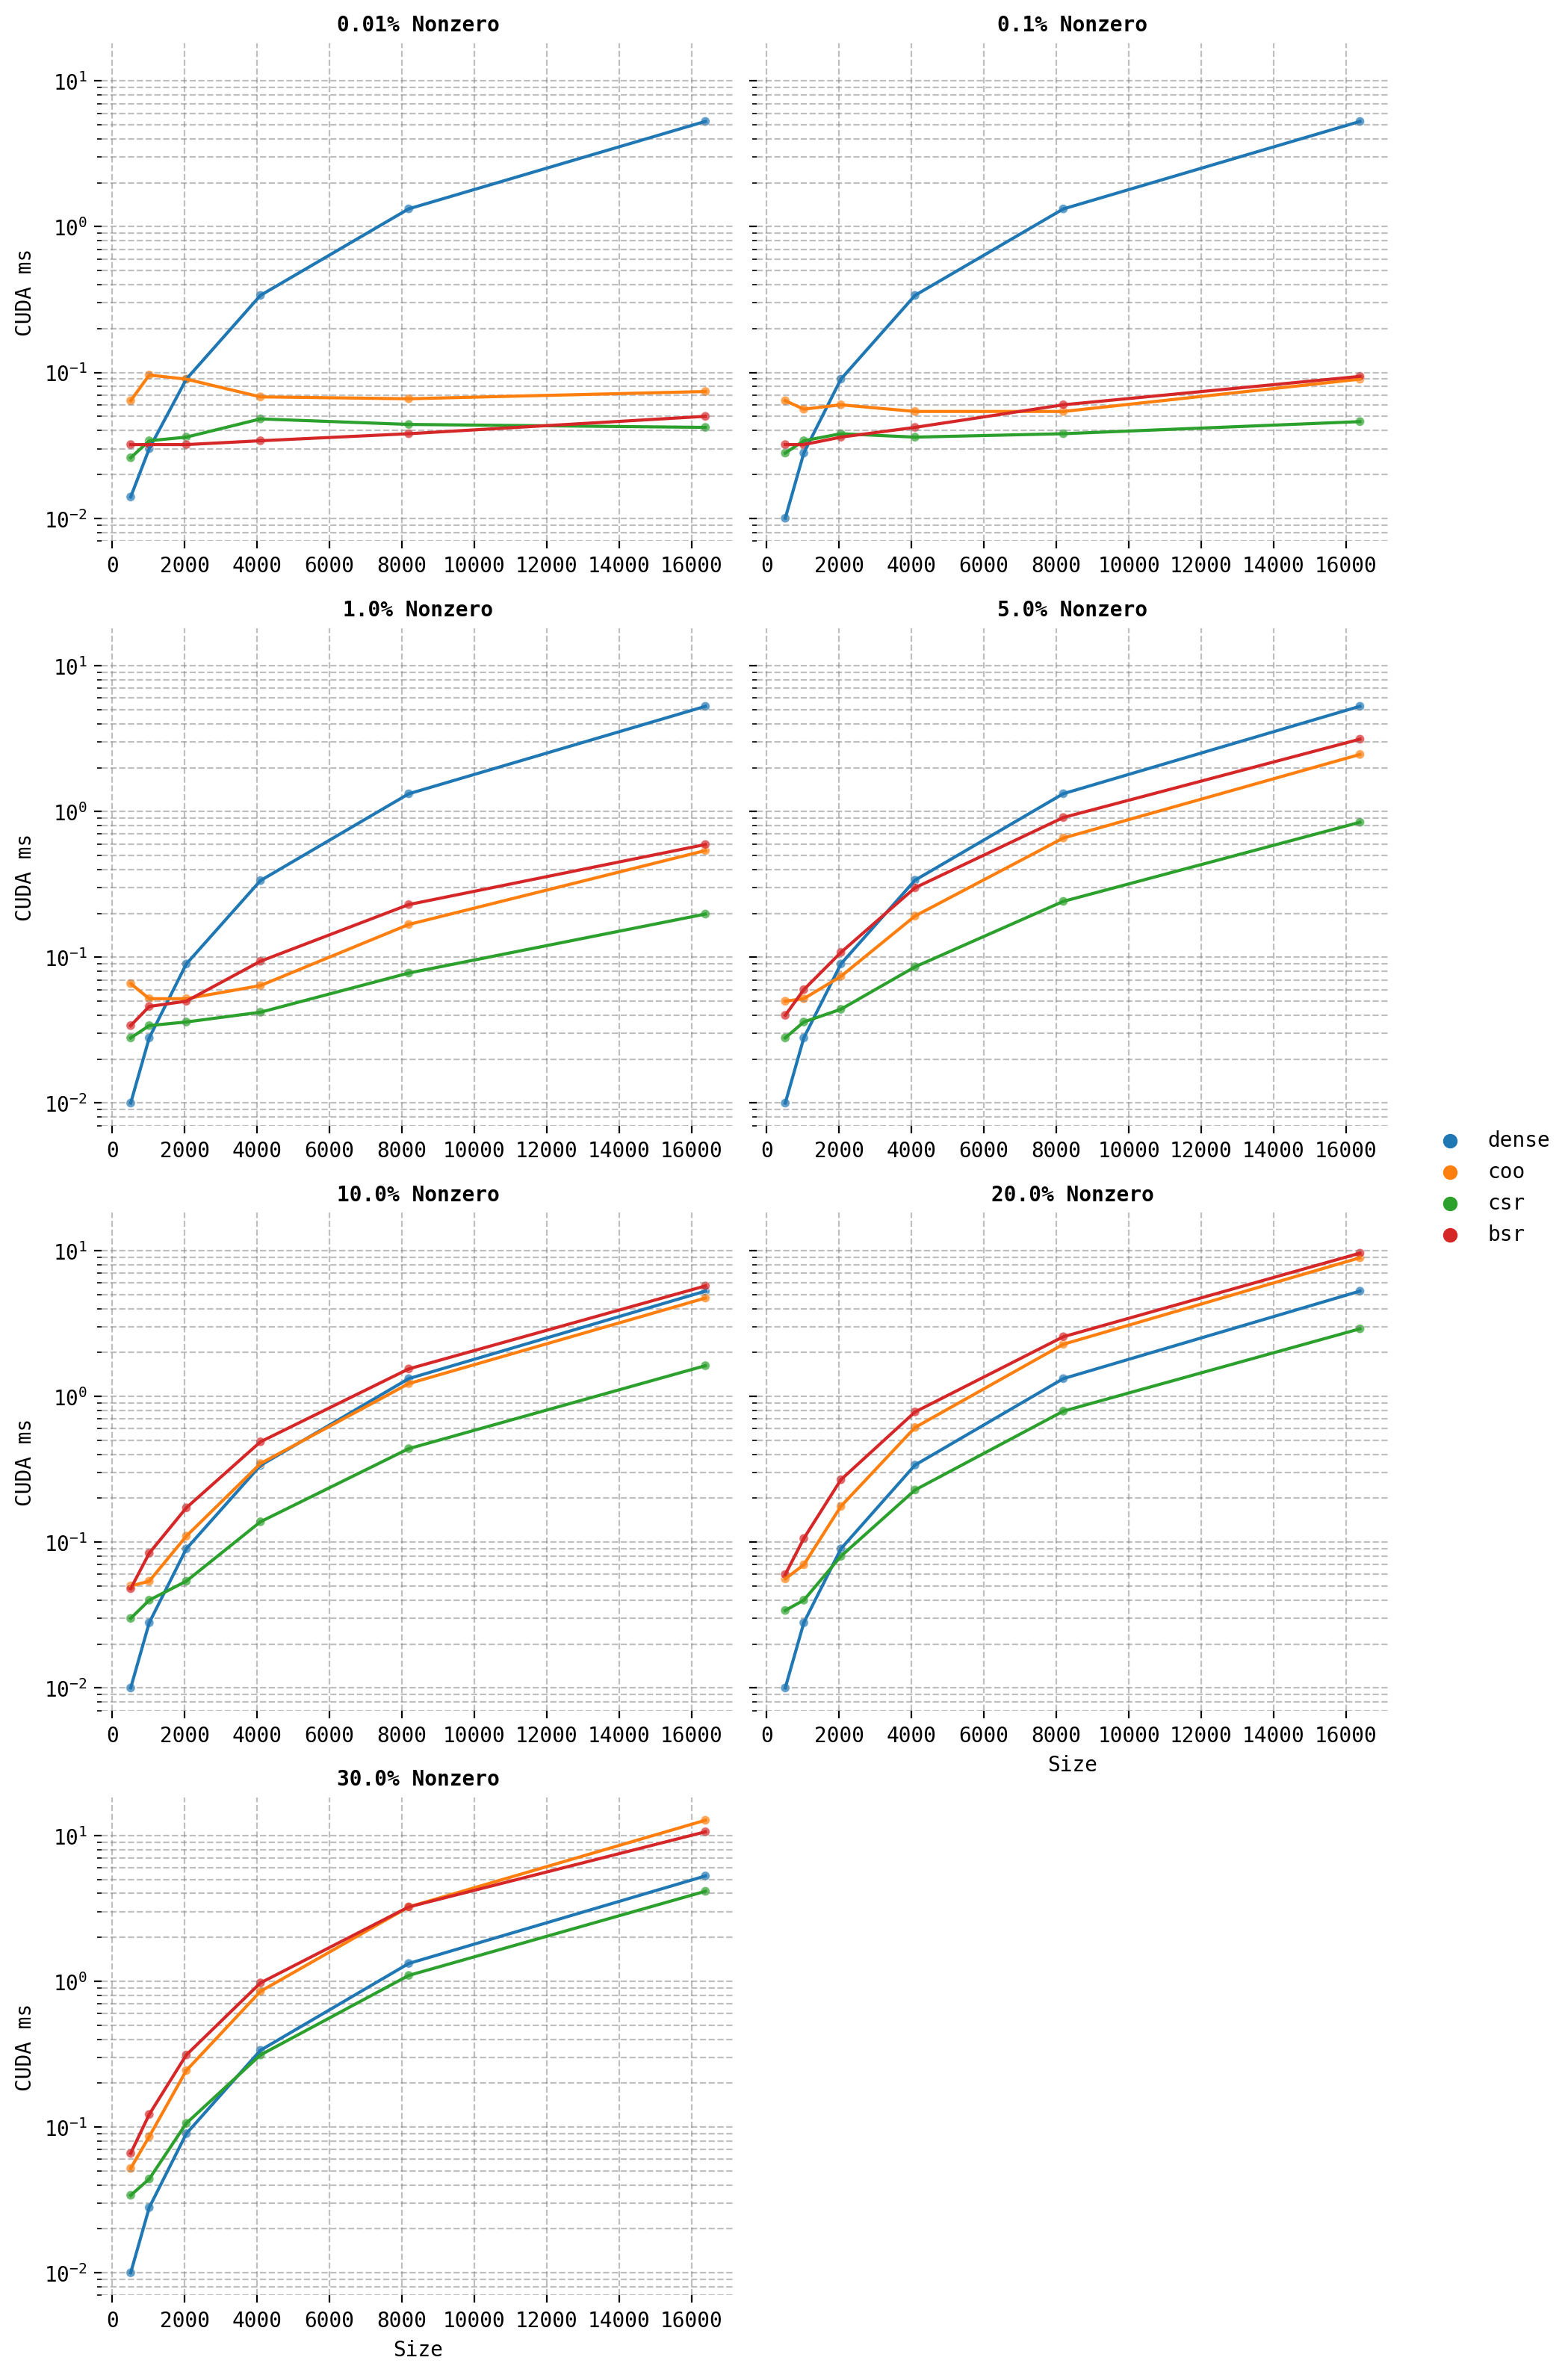

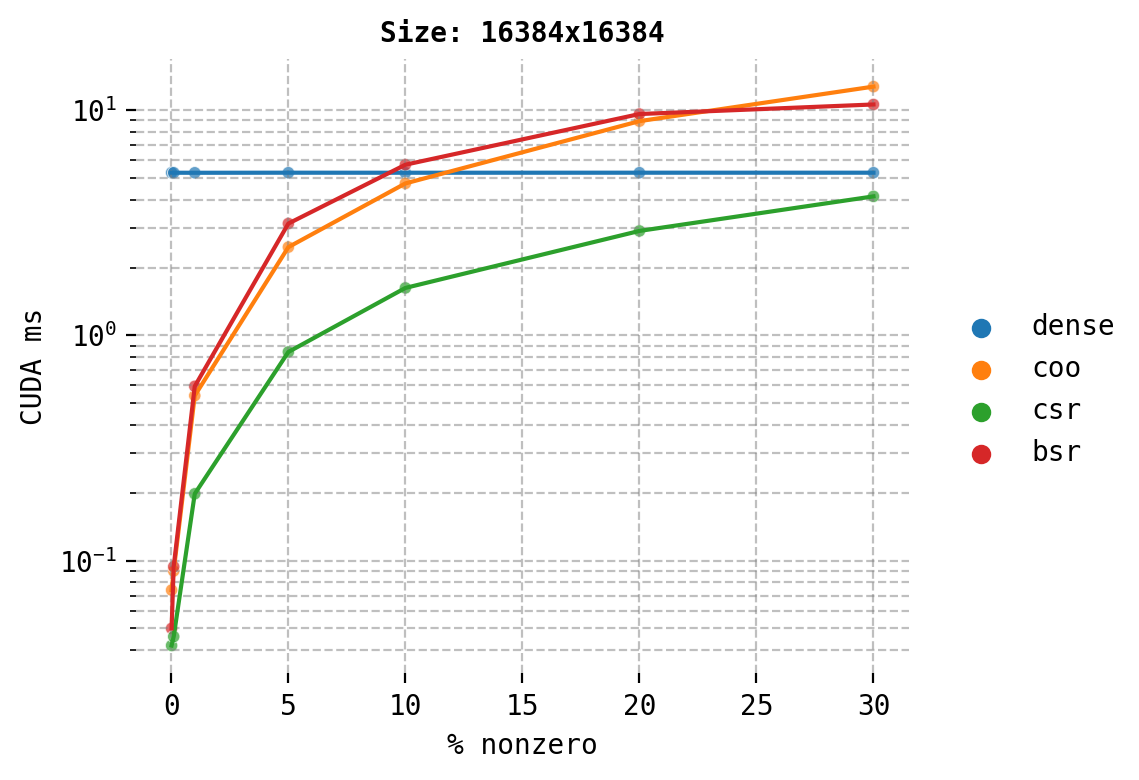

In [6]:
# Create the lineplots with log y-scale and dots
g = sns.FacetGrid(
    df,
    col="percentage_nonzero",
    height=4,
    aspect=1.2,
    col_wrap=2,
    sharey=True,
    sharex=False,
)
g.map(sns.lineplot, "size", "cuda_millis", "name")
g.map(sns.scatterplot, "size", "cuda_millis", "name", color="black", alpha=0.7, s=20)
g.set(yscale="log")

# Set the titles and labels
g.set_titles(col_template="{col_name}% Nonzero", fontweight="bold")
g.set_axis_labels("Size", "CUDA ms")

# Add legend
g.add_legend()

# add grid
g.despine(left=True, bottom=True)
g.map(plt.grid, which="both", axis="both", ls="--", color="grey", alpha=0.5)

# Show the plot
plt.show()
# save the plot
g.savefig(f"torch_sparse_plot_cuda.png")

# largest size only
sub_df = df[df["size"] == df["size"].max()]
g = sns.FacetGrid(sub_df, col="size", height=4, aspect=1.2, sharey=True, sharex=False)
g.map(sns.lineplot, "percentage_nonzero", "cuda_millis", "name")
g.map(
    sns.scatterplot,
    "percentage_nonzero",
    "cuda_millis",
    "name",
    color="black",
    alpha=0.7,
    s=20,
)
g.set(yscale="log")

# Set the titles and labels
g.set_titles(col_template="Size: {col_name}x{col_name}", fontweight="bold")
g.set_axis_labels("% nonzero", "CUDA ms")

# Add legend
g.add_legend()

# add grid
g.despine(left=True, bottom=True)
g.map(plt.grid, which="both", axis="both", ls="--", color="grey", alpha=0.5)

# Show the plot
plt.show()
g.savefig("torch_sparse_plot_largest.png")